In [2]:
import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.patches import Patch

from config import ORDER

# embeddings
focal_embeddings = np.load('../data/focal_embeddings.npy')
focal_abstract_embeddings = np.load('../data/focal_abstract_embeddings.npy')
ground_truth_embeddings = np.load('../data/ground_truth_embeddings.npy')
generated_embeddings = np.load('../data/generated_embeddings.npy')

focal_embeddings_openai = np.load('../data/focal_embeddings_openai.npy')
focal_abstract_embeddings_openai = np.load('../data/focal_abstracts_embeddings_openai.npy')
ground_truth_embeddings_openai = np.load('../data/ground_truth_embeddings_openai.npy')
generated_embeddings_openai = np.load('../data/generated_embeddings_openai.npy')

# normalize (not needed for openai, already normalized)
focal_norms = np.linalg.norm(focal_embeddings, axis=1, keepdims=True)
focal_embeddings = focal_embeddings / focal_norms

focal_abstract_norms = np.linalg.norm(focal_abstract_embeddings, axis=1, keepdims=True)
focal_abstract_embeddings = focal_abstract_embeddings / focal_abstract_norms

ground_truth_norms = np.linalg.norm(ground_truth_embeddings, axis=1, keepdims=True)
ground_truth_embeddings = ground_truth_embeddings / ground_truth_norms

generated_norms = np.linalg.norm(generated_embeddings, axis=1, keepdims=True)
generated_embeddings = generated_embeddings / generated_norms

# data
df_sample = pd.read_csv("../data/focal_papers.csv")
df_generated = pd.read_csv("../data/generated_references.csv")
df_ground_truth = pd.read_csv("../data/ground_truth_references.csv")

/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_17441/98354074.py:39: DtypeWarning: Columns (4,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df_generated = pd.read_csv("../data/generated_references.csv")


In [3]:
# sort embeddings
focal_embeddings_dict = {k: {} for k in ORDER}
for citing_paper_id, group_df in df_sample.groupby('PaperID'):
    top_field = group_df['top_field'].iloc[0]
    row_indices = group_df.index.values
    focal_embeddings_dict[top_field][citing_paper_id] = focal_embeddings[row_indices]

focal_abstract_embeddings_dict = {k: {} for k in ORDER}
for citing_paper_id, group_df in df_sample.groupby('PaperID'):
    top_field = group_df['top_field'].iloc[0]
    row_indices = group_df.index.values
    focal_abstract_embeddings_dict[
        top_field
    ][citing_paper_id] = focal_abstract_embeddings[row_indices]

ground_truth_embeddings_dict = {k: {} for k in ORDER}
for citing_paper_id, group_df in df_ground_truth.groupby('Citing_PaperID'):
    top_field = group_df['top_field'].iloc[0]
    row_indices = group_df.index.values
    ground_truth_embeddings_dict[top_field][citing_paper_id] = ground_truth_embeddings[row_indices]

generated_embeddings_dict = {k: {} for k in ORDER}
for citing_paper_id, group_df in df_generated.groupby('id'):
    top_field = group_df['top_field'].iloc[0]
    row_indices = group_df.index.values
    generated_embeddings_dict[top_field][citing_paper_id] = generated_embeddings[row_indices]

# sort openai embeddings
focal_embeddings_dict_openai = {k: {} for k in ORDER}
for citing_paper_id, group_df in df_sample.groupby('PaperID'):
    top_field = group_df['top_field'].iloc[0]
    row_indices = group_df.index.values
    focal_embeddings_dict_openai[top_field][citing_paper_id] = focal_embeddings_openai[row_indices]

focal_abstract_embeddings_dict_openai = {k: {} for k in ORDER}
for citing_paper_id, group_df in df_sample.groupby('PaperID'):
    top_field = group_df['top_field'].iloc[0]
    row_indices = group_df.index.values
    focal_abstract_embeddings_dict_openai[
        top_field
    ][citing_paper_id] = focal_abstract_embeddings_openai[row_indices]

ground_truth_embeddings_dict_openai = {k: {} for k in ORDER}
for citing_paper_id, group_df in df_ground_truth.groupby('Citing_PaperID'):
    top_field = group_df['top_field'].iloc[0]
    row_indices = group_df.index.values
    ground_truth_embeddings_dict_openai[top_field][citing_paper_id] = ground_truth_embeddings_openai[row_indices]

generated_embeddings_dict_openai = {k: {} for k in ORDER}
for citing_paper_id, group_df in df_generated.groupby('id'):
    top_field = group_df['top_field'].iloc[0]
    row_indices = group_df.index.values
    generated_embeddings_dict_openai[top_field][citing_paper_id] = generated_embeddings_openai[row_indices]

In [4]:
# compute all other individual cosine similarities
# openai
random_individual_similarities_openai_dict = {k: {} for k in ORDER}
ground_truth_individual_similarities_openai_dict = {k: {} for k in ORDER}
generated_individual_similarities_openai_dict = {k: {} for k in ORDER}
existing_individual_similarities_openai_dict = {k: {} for k in ORDER}
non_existent_individual_similarities_openai_dict = {k: {} for k in ORDER}


for k in df_sample["PaperID"].to_list():

    relevant_field = df_sample.loc[df_sample["PaperID"] == k, "top_field"].values[0]
    random_k = random.choice(
        [n for n in list(ground_truth_embeddings_dict_openai[relevant_field]) if n != k]
    )  # not same paper

    random_individual_similarities_openai_dict[relevant_field][k] = cosine_similarity(
        focal_embeddings_dict_openai[relevant_field][k],
        ground_truth_embeddings_dict_openai[relevant_field][random_k],
    )

    ground_truth_individual_similarities_openai_dict[relevant_field][k] = cosine_similarity(
        focal_embeddings_dict_openai[relevant_field][k],
        ground_truth_embeddings_dict_openai[relevant_field][k],
    )

    if k in generated_embeddings_dict_openai[relevant_field]:
        existing_ids = df_generated.loc[df_generated.id == k, "Exists"].astype(bool).values

        generated_individual_similarities_openai_dict[relevant_field][k] = cosine_similarity(
            focal_embeddings_dict_openai[relevant_field][k],
            generated_embeddings_dict_openai[relevant_field][k],
        )

        if sum(existing_ids) == 0:
            continue
        else:
            existing_individual_similarities_openai_dict[relevant_field][k] = cosine_similarity(
                focal_embeddings_dict_openai[relevant_field][k],
                generated_embeddings_dict_openai[relevant_field][k][existing_ids],
            )

        if sum(existing_ids) == len(df_generated.loc[df_generated.id == k, "Exists"]):
            continue
        else:
            non_existent_individual_similarities_openai_dict[relevant_field][k] = cosine_similarity(
                focal_embeddings_dict_openai[relevant_field][k],
                generated_embeddings_dict_openai[relevant_field][k][~existing_ids],
            )

random_individual_similarities_openai = {
    field: np.array(
        [val for arr in field_dict.values() for val in arr.flatten()],
        dtype=np.float32
    )
    for field, field_dict in random_individual_similarities_openai_dict.items()
}

ground_truth_individual_similarities_openai = {
    field: np.array(
        [val for arr in field_dict.values() for val in arr.flatten()],
        dtype=np.float32
    )
    for field, field_dict in ground_truth_individual_similarities_openai_dict.items()
}

generated_individual_similarities_openai = {
    field: np.array(
        [val for arr in field_dict.values() for val in arr.flatten()],
        dtype=np.float32
    )
    for field, field_dict in generated_individual_similarities_openai_dict.items()
}

existing_individual_similarities_openai = {
    field: np.array(
        [val for arr in field_dict.values() for val in arr.flatten()],
        dtype=np.float32
    )
    for field, field_dict in existing_individual_similarities_openai_dict.items()
}

non_existent_individual_similarities_openai = {
    field: np.array(
        [val for arr in field_dict.values() for val in arr.flatten()],
        dtype=np.float32
    )
    for field, field_dict in non_existent_individual_similarities_openai_dict.items()
}

data_sources_openai = [
    (random_individual_similarities_openai,       "random"),
    (ground_truth_individual_similarities_openai, "groundtruth"),
    (generated_individual_similarities_openai,    "gen"),
    (existing_individual_similarities_openai,     "existing"),
    (non_existent_individual_similarities_openai, "non_existent"),
]

records_openai = [
    {"field": field, "similarity": val, "source": label}
    for data_dict, label in data_sources_openai
    for field, arr in data_dict.items()
    for val in arr
]

df_openai = pd.DataFrame(records_openai)

In [5]:
# compute all other individual cosine similarities
# specter
random_individual_similarities_dict_specter = {k: {} for k in ORDER}
ground_truth_individual_similarities_dict_specter = {k: {} for k in ORDER}
generated_individual_similarities_dict_specter = {k: {} for k in ORDER}
existing_individual_similarities_dict_specter = {k: {} for k in ORDER}
non_existent_individual_similarities_dict_specter = {k: {} for k in ORDER}

for k in df_sample["PaperID"].to_list():

    relevant_field = df_sample.loc[df_sample["PaperID"] == k, "top_field"].values[0]
    random_k = random.choice(
        [n for n in list(ground_truth_embeddings_dict[relevant_field]) if n != k]
    )  # not same paper

    random_individual_similarities_dict_specter[
        relevant_field
    ][k] = cosine_similarity(
        focal_embeddings_dict[relevant_field][k],
        ground_truth_embeddings_dict[relevant_field][random_k],
    )

    ground_truth_individual_similarities_dict_specter[
        relevant_field
    ][k] = cosine_similarity(
        focal_embeddings_dict[relevant_field][k],
        ground_truth_embeddings_dict[relevant_field][k],
    )

    if k in generated_embeddings_dict[relevant_field]:
        existing_ids = df_generated.loc[df_generated.id == k, "Exists"].astype(bool).values

        generated_individual_similarities_dict_specter[
            relevant_field
        ][k] = cosine_similarity(
            focal_embeddings_dict[relevant_field][k],
            generated_embeddings_dict[relevant_field][k],
        )

        if sum(existing_ids) == 0:
            continue
        else:
            existing_individual_similarities_dict_specter[
                relevant_field
            ][k] = cosine_similarity(
                focal_embeddings_dict[relevant_field][k],
                generated_embeddings_dict[relevant_field][k][existing_ids],
            )

        if sum(existing_ids) == len(df_generated.loc[df_generated.id == k, "Exists"]):
            continue
        else:
            non_existent_individual_similarities_dict_specter[
                relevant_field
            ][k] = cosine_similarity(
                focal_embeddings_dict[relevant_field][k],
                generated_embeddings_dict[relevant_field][k][~existing_ids],
            )

random_individual_similarities_specter = {
    field: np.array(
        [val for arr in field_dict.values() for val in arr.flatten()],
        dtype=np.float32
    )
    for field, field_dict in random_individual_similarities_dict_specter.items()
}

ground_truth_individual_similarities_specter = {
    field: np.array(
        [val for arr in field_dict.values() for val in arr.flatten()],
        dtype=np.float32
    )
    for field, field_dict in ground_truth_individual_similarities_dict_specter.items()
}

generated_individual_similarities_specter = {
    field: np.array(
        [val for arr in field_dict.values() for val in arr.flatten()],
        dtype=np.float32
    )
    for field, field_dict in generated_individual_similarities_dict_specter.items()
}

existing_individual_similarities_specter = {
    field: np.array(
        [val for arr in field_dict.values() for val in arr.flatten()],
        dtype=np.float32
    )
    for field, field_dict in existing_individual_similarities_dict_specter.items()
}

non_existent_individual_similarities_specter = {
    field: np.array(
        [val for arr in field_dict.values() for val in arr.flatten()],
        dtype=np.float32
    )
    for field, field_dict in non_existent_individual_similarities_dict_specter.items()
}

data_sources_specter = [
    (random_individual_similarities_specter,       "random"),
    (ground_truth_individual_similarities_specter, "groundtruth"),
    (generated_individual_similarities_specter,    "gen"),
    (existing_individual_similarities_specter,     "existing"),
    (non_existent_individual_similarities_specter, "non_existent"),
]

records_specter = [
    {"field": field, "similarity": val, "source": label}
    for data_dict, label in data_sources_specter
    for field, arr in data_dict.items()
    for val in arr
]

df_specter = pd.DataFrame(records_specter)

In [6]:
# compute all other individual cosine similarities
# abstract_specter
random_individual_similarities_dict_abstract_specter = {k: {} for k in ORDER}
ground_truth_individual_similarities_dict_abstract_specter = {k: {} for k in ORDER}
generated_individual_similarities_dict_abstract_specter = {k: {} for k in ORDER}
existing_individual_similarities_dict_abstract_specter = {k: {} for k in ORDER}
non_existent_individual_similarities_dict_abstract_specter = {k: {} for k in ORDER}

for k in df_sample["PaperID"].to_list():

    relevant_field = df_sample.loc[df_sample["PaperID"] == k, "top_field"].values[0]
    random_k = random.choice(
        [n for n in list(ground_truth_embeddings_dict[relevant_field]) if n != k]
    )  # not same paper

    random_individual_similarities_dict_abstract_specter[
        relevant_field
    ][k] = cosine_similarity(
        focal_abstract_embeddings_dict[relevant_field][k],
        ground_truth_embeddings_dict[relevant_field][random_k],
    )

    ground_truth_individual_similarities_dict_abstract_specter[
        relevant_field
    ][k] = cosine_similarity(
        focal_abstract_embeddings_dict[relevant_field][k],
        ground_truth_embeddings_dict[relevant_field][k],
    )

    if k in generated_embeddings_dict[relevant_field]:
        existing_ids = df_generated.loc[df_generated.id == k, "Exists"].astype(bool).values

        generated_individual_similarities_dict_abstract_specter[
            relevant_field
        ][k] = cosine_similarity(
            focal_abstract_embeddings_dict[relevant_field][k],
            generated_embeddings_dict[relevant_field][k],
        )

        if sum(existing_ids) == 0:
            continue
        else:
            existing_individual_similarities_dict_abstract_specter[
                relevant_field
            ][k] = cosine_similarity(
                focal_abstract_embeddings_dict[relevant_field][k],
                generated_embeddings_dict[relevant_field][k][existing_ids],
            )

        if sum(existing_ids) == len(df_generated.loc[df_generated.id == k, "Exists"]):
            continue
        else:
            non_existent_individual_similarities_dict_abstract_specter[
                relevant_field
            ][k] = cosine_similarity(
                focal_abstract_embeddings_dict[relevant_field][k],
                generated_embeddings_dict[relevant_field][k][~existing_ids],
            )

random_individual_similarities_abstract_specter = {
    field: np.array(
        [val for arr in field_dict.values() for val in arr.flatten()],
        dtype=np.float32
    )
    for field, field_dict in random_individual_similarities_dict_abstract_specter.items()
}

ground_truth_individual_similarities_abstract_specter = {
    field: np.array(
        [val for arr in field_dict.values() for val in arr.flatten()],
        dtype=np.float32
    )
    for field, field_dict in ground_truth_individual_similarities_dict_abstract_specter.items()
}

generated_individual_similarities_abstract_specter = {
    field: np.array(
        [val for arr in field_dict.values() for val in arr.flatten()],
        dtype=np.float32
    )
    for field, field_dict in generated_individual_similarities_dict_abstract_specter.items()
}

existing_individual_similarities_abstract_specter = {
    field: np.array(
        [val for arr in field_dict.values() for val in arr.flatten()],
        dtype=np.float32
    )
    for field, field_dict in existing_individual_similarities_dict_abstract_specter.items()
}

non_existent_individual_similarities_abstract_specter = {
    field: np.array(
        [val for arr in field_dict.values() for val in arr.flatten()],
        dtype=np.float32
    )
    for field, field_dict in non_existent_individual_similarities_dict_abstract_specter.items()
}

data_sources_abstract_specter = [
    (random_individual_similarities_abstract_specter,       "random"),
    (ground_truth_individual_similarities_abstract_specter, "groundtruth"),
    (generated_individual_similarities_abstract_specter,    "gen"),
    (existing_individual_similarities_abstract_specter,     "existing"),
    (non_existent_individual_similarities_abstract_specter, "non_existent"),
]

records_abstract_specter = [
    {"field": field, "similarity": val, "source": label}
    for data_dict, label in data_sources_abstract_specter
    for field, arr in data_dict.items()
    for val in arr
]

df_abstract_specter = pd.DataFrame(records_abstract_specter)

/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_17441/3773348519.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1["A"].set_yticklabels(


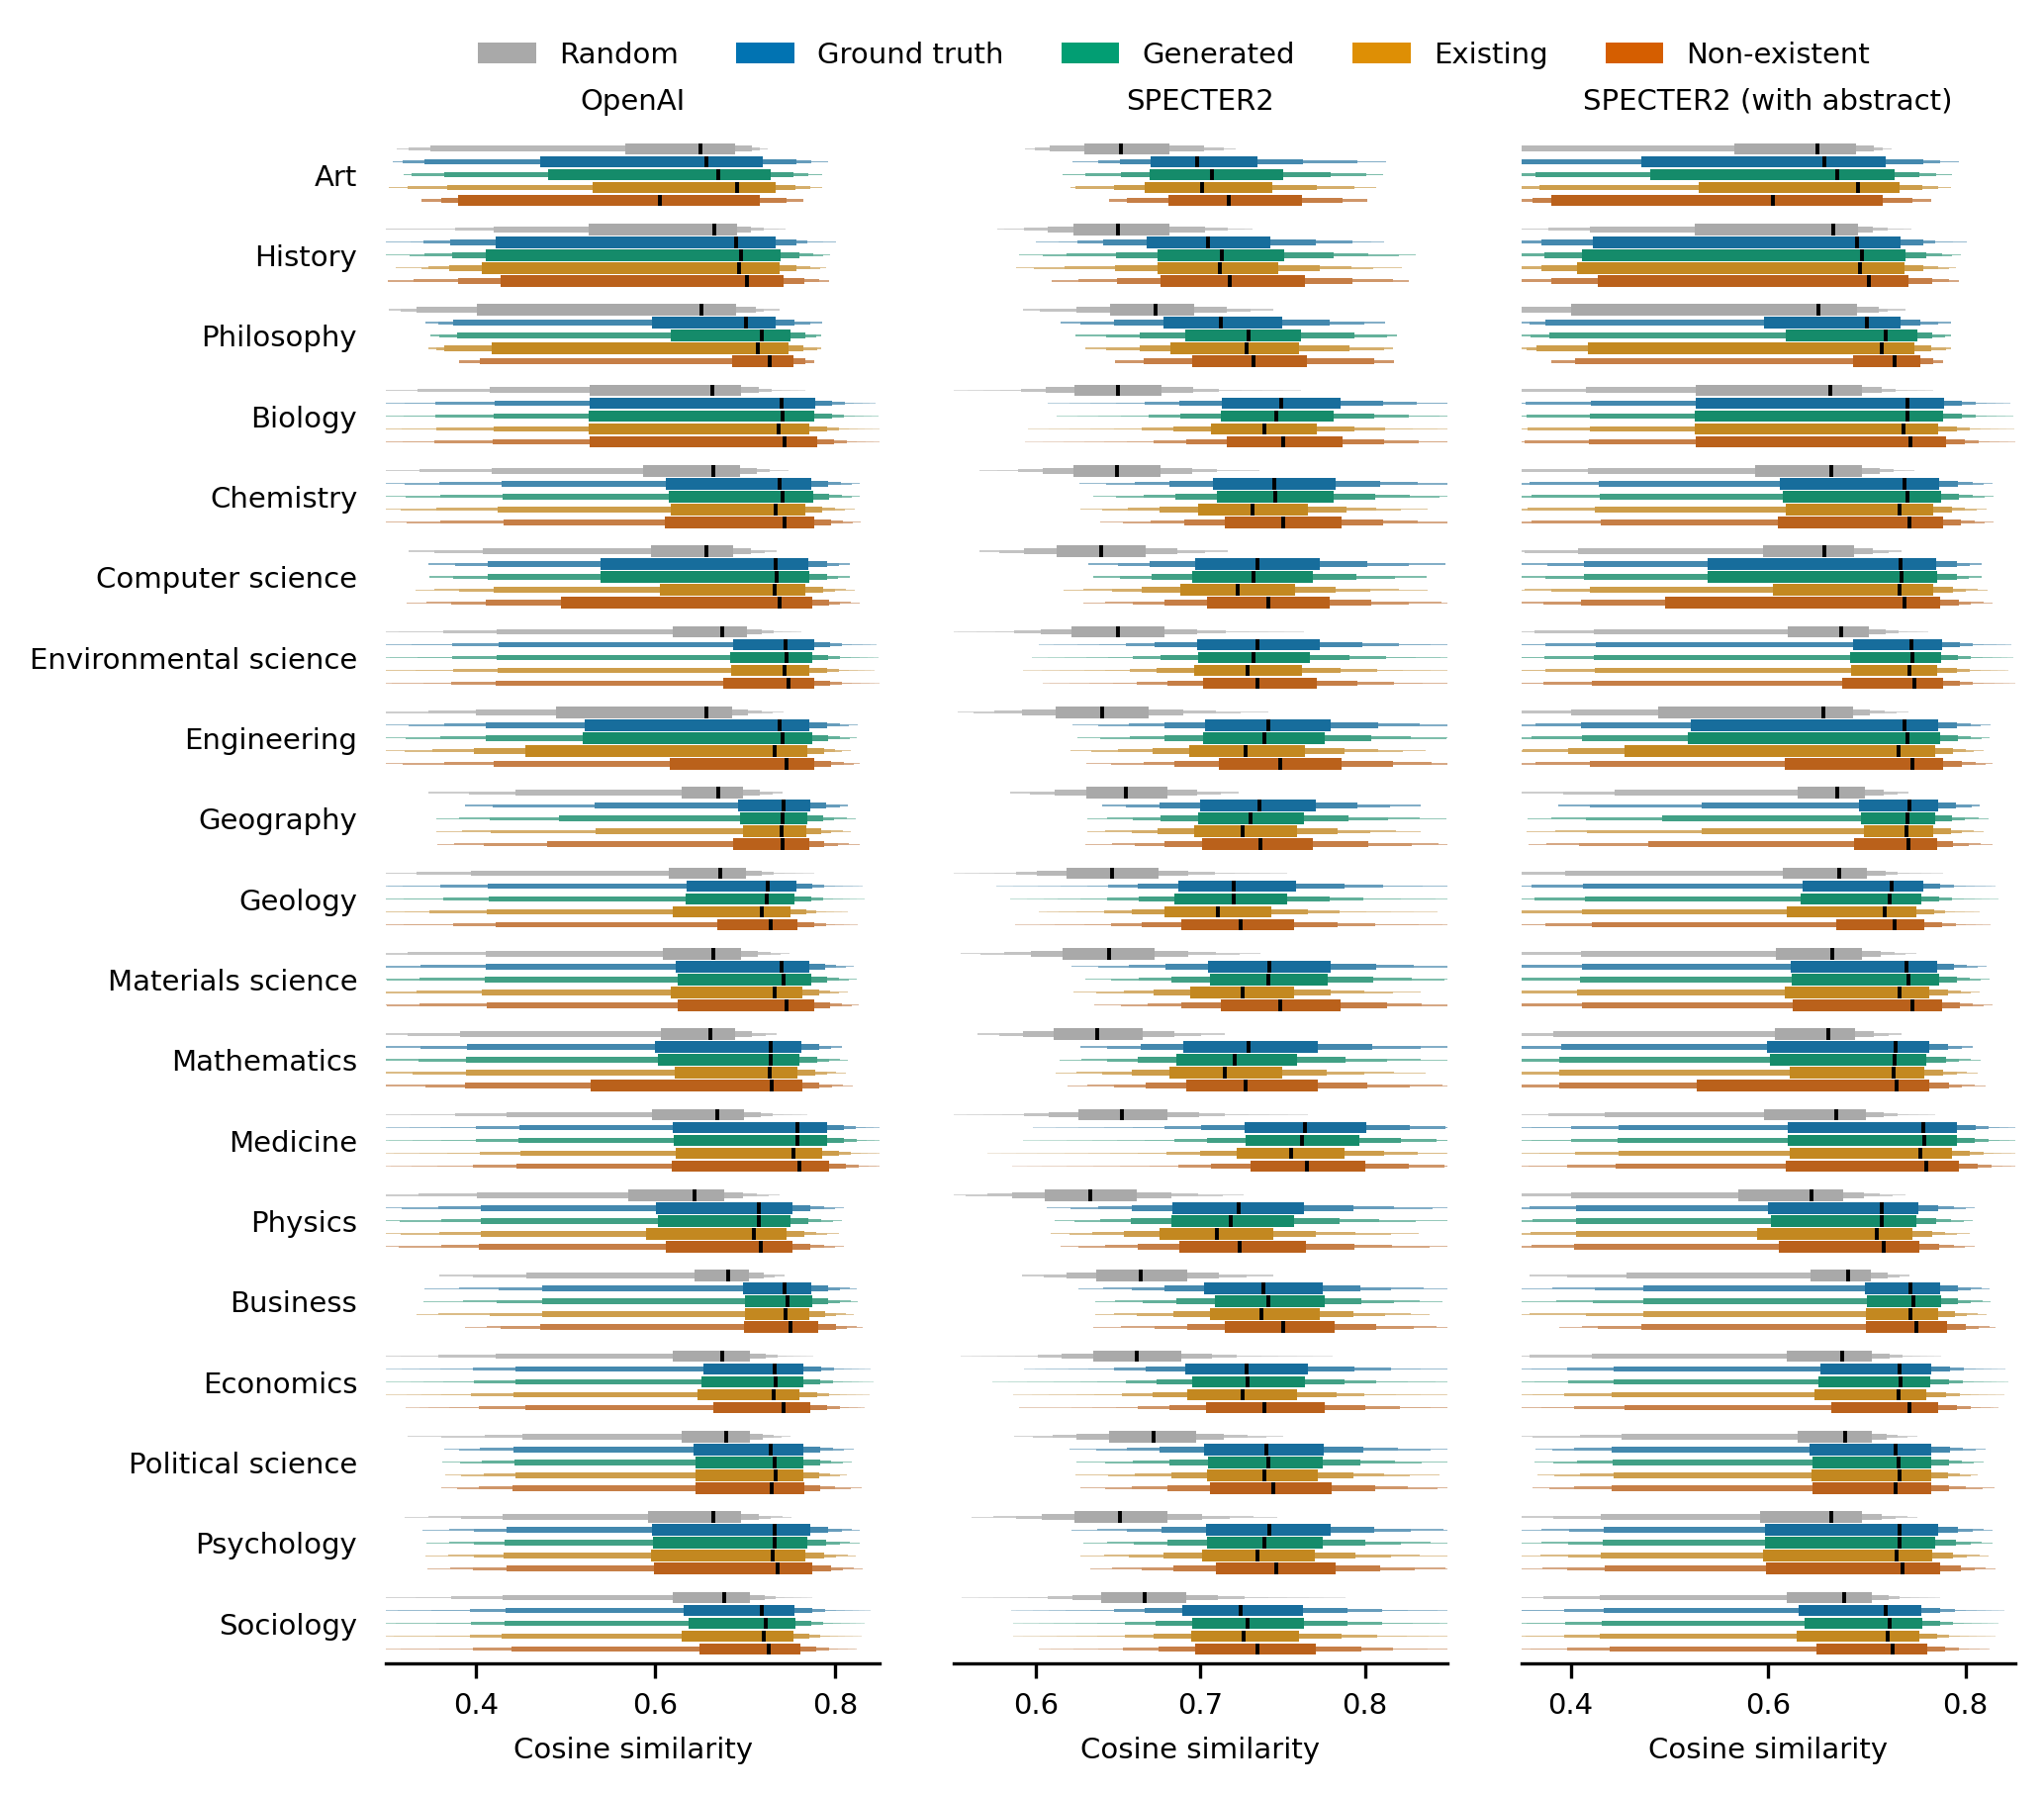

In [7]:
Figure1, ax1 = plt.subplot_mosaic(
    [
        ['A', 'B', 'C'],
    ],
    figsize=(7.08, 6.69),
    dpi=300,
    gridspec_kw={'wspace': 0.15, 'hspace': 0.25},  # Adjust spacing
)

YLABEL = [
    'Art',
    'History',
    'Philosophy',
    'Biology',
    'Chemistry',
    'Computer science',
    'Environmental science',
    'Engineering',
    'Geography',
    'Geology',
    'Materials science',
    'Mathematics',
    'Medicine',
    'Physics',
    'Business',
    'Economics',
    'Political science',
    'Psychology',
    'Sociology',
]

# A
sns.boxenplot(
    data=df_abstract_specter,
    x="similarity",
    y="field", 
    hue="source",
    hue_order=["random", "groundtruth", "gen", "existing", "non_existent"],
    palette=["darkgray", "#0173b2", "#029e73", "#de8f05", "#d55e00"],
    gap=0.1,
    edgecolor=None,
    linecolor='black',
    showfliers=False,
    legend=False,
    ax=ax1['A'],
)

ax1["A"].set_title("OpenAI", fontsize=7,)
ax1["A"].set(xlim=(0.3, 0.85))
ax1["A"].set_ylabel("", fontsize=7)
ax1["A"].set_xlabel("Cosine similarity", fontsize=7, rotation=0)

ax1["A"].set_yticklabels(
    labels=YLABEL,
    fontsize=7,
)

ax1["A"].set_xticks(
    [0.4, 0.6, 0.8],
    labels=[0.4, 0.6, 0.8],
    fontsize=7,
)

ax1["A"].xaxis.set_tick_params() # pad=-10

ax1["A"].tick_params(left=False)
sns.despine(ax=ax1["A"],left=True, bottom=False)

# B
sns.boxenplot(
    data=df_specter,
    x="similarity",
    y="field", 
    hue="source",
    hue_order=["random", "groundtruth", "gen", "existing", "non_existent"],
    palette=["darkgray", "#0173b2", "#029e73", "#de8f05", "#d55e00"],
    gap=0.1,
    edgecolor=None,
    linecolor='black',
    showfliers=False,
    legend=False,
    ax=ax1['B'],
)

ax1["B"].set_title("SPECTER2", fontsize=7,)
ax1["B"].set(xlim=(0.55, 0.85))
ax1["B"].set_ylabel("", fontsize=7)
ax1["B"].set_xlabel("Cosine similarity", fontsize=7, rotation=0)

ax1["B"].set_yticklabels(
    labels=[],
    fontsize=7,
)

ax1["B"].set_xticks(
    [0.6, 0.7, 0.8],
    labels=[0.6, 0.7, 0.8],
    fontsize=7,
)

ax1["B"].xaxis.set_tick_params() # pad=-10

ax1["B"].tick_params(left=False)
sns.despine(ax=ax1["B"],left=True, bottom=False)

# C
sns.boxenplot(
    data=df_abstract_specter,
    x="similarity",
    y="field", 
    hue="source",
    hue_order=["random", "groundtruth", "gen", "existing", "non_existent"],
    palette=["darkgray", "#0173b2", "#029e73", "#de8f05", "#d55e00"],
    gap=0.1,
    edgecolor=None,
    linecolor='black',
    showfliers=False,
    legend=False,
    ax=ax1['C'],
)

ax1["C"].set_title("SPECTER2 (with abstract)", fontsize=7,)
ax1["C"].set(xlim=(0.35, 0.85))
ax1["C"].set_ylabel("", fontsize=7)
ax1["C"].set_xlabel("Cosine similarity", fontsize=7, rotation=0)

ax1["C"].set_yticklabels(
    labels=[],
    fontsize=7,
)

ax1["C"].set_xticks(
    [0.4, 0.6, 0.8],
    labels=[0.4, 0.6, 0.8],
    fontsize=7,
)

ax1["C"].xaxis.set_tick_params() # pad=-10

ax1["C"].tick_params(left=False)
sns.despine(ax=ax1["C"],left=True, bottom=False)

# legend
legend_elements = [
    Patch(facecolor='darkgray', edgecolor=None, label='Random'),
    Patch(facecolor='#0173b2', edgecolor=None, label='Ground truth'),
    Patch(facecolor='#029e73', edgecolor=None, label='Generated'),
    Patch(facecolor='#de8f05', edgecolor=None, label='Existing'),
    Patch(facecolor='#d55e00', edgecolor=None, label='Non-existent'),
]

ax1["C"].legend(
    handles=legend_elements,
    loc='upper center',
    title='',
    title_fontsize=7,
    fontsize=7,
    frameon=False,
    bbox_transform=Figure1.transFigure,
    ncol=5,
    bbox_to_anchor=(0.5, 0.94),
)